# 空气污染序列预测

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

tf.__version__

'2.0.0'

In [2]:
data = pd.read_csv('dataset/PRSA_data.csv')
data

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


## 处理数据

### 处理pm2.5中的nan值

In [3]:
# 删除前面所有pm2.5为nan的行
data = data.iloc[24:].copy()
data

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
24,25,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0
25,26,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0
26,27,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0
27,28,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0
28,29,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [4]:
# 将中间的nan用前面的数据进行填充
data.fillna(method='ffill', inplace=True)

In [5]:
# 将'No'这一列去掉
data.drop('No', axis=1, inplace=True)

### 处理时间序列，将时间设置为索引

In [6]:
# 将年月日小时的合成一个新的time列
import datetime
data['time'] = data.apply(lambda x: datetime.datetime(year=x['year'],
                                                      month=x['month'],
                                                      day=x['day'], 
                                                      hour=x['hour']), axis=1)
# 删除'year', 'month', 'day', 'hour'列
data.drop(columns=['year', 'month', 'day', 'hour'], inplace=True)
# 将时间这一列设置为索引
data.set_index('time', inplace=True)
data

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
time,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


In [7]:
# 修改列名
data.columns = ['pm2.5', 'dew', 'temp', 'press', 'cbwd', 'iws', 'snow', 'rain']

### 处理cbwd（表示风向）列

In [8]:
# cbwd的值
data.cbwd.unique()

array(['SE', 'cv', 'NW', 'NE'], dtype=object)

In [9]:
# 将cbwd的值改为独热编码
data = data.join(pd.get_dummies(data.cbwd))
del data['cbwd']
data

,pm2.5,dew,temp,press,iws,snow,rain,NE,NW,SE,cv
time,,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,231.97,0,0,0,1,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,237.78,0,0,0,1,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,242.70,0,0,0,1,0,0


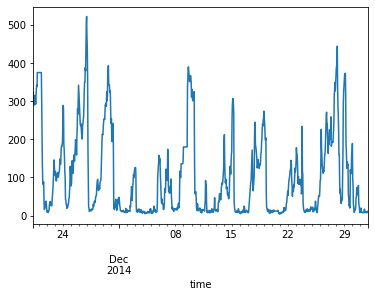

In [10]:
# 画出后1000天的pm2.5
data['pm2.5'][-1000:].plot()

### 在数据中采样训练集和标签

In [11]:
# 用前面的5天的特征，来预测后面一天的pm2.5值
sequence_length = 5 * 24
delay = 24

In [12]:
# 相邻6天的数据为1组，6天中最后一天的pm2.5值为标签
data_ = []
for i in range(len(data) - sequence_length - delay):
    data_.append(data.iloc[i: i + sequence_length + delay])
data_[0]

,pm2.5,dew,temp,press,iws,snow,rain,NE,NW,SE,cv
time,,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2010-01-07 19:00:00,67.0,-18,-11.0,1033.0,1.79,0,0,0,1,0,0
2010-01-07 20:00:00,106.0,-19,-15.0,1032.0,1.79,0,0,1,0,0,0
2010-01-07 21:00:00,159.0,-19,-14.0,1032.0,0.45,0,0,0,0,0,1


In [13]:
data_[0].values

array([[129., -16.,  -4., ...,   0.,   1.,   0.],
       [148., -15.,  -4., ...,   0.,   1.,   0.],
       [159., -11.,  -5., ...,   0.,   1.,   0.],
       ...,
       [159., -19., -14., ...,   0.,   0.,   1.],
       [198., -21., -14., ...,   0.,   0.,   1.],
       [190., -21., -16., ...,   0.,   0.,   1.]])

In [14]:
# 将列表中每一个dataframe对象转为ndarray对象
data_ = np.array([df.values for df in data_])
data_.shape

(43656, 144, 11)

In [15]:
# 将数据打乱
np.random.shuffle(data_)

In [16]:
# 将每一组数据中的前面五天作为特征，最后一天的pm2.5值为标签
x = data_[:, :sequence_length, :]
y = data_[:, -delay:, 0]
x.shape, y.shape

((43656, 120, 11), (43656, 24))

In [17]:
# 分离训练集和验证集
train_num = int(data_.shape[0] * 0.8)

train_x = x[: train_num]
val_x = x[train_num:]

train_y = y[: train_num]
val_y = y[train_num:]

In [18]:
train_x.shape, val_x.shape, train_y.shape, val_y.shape

((34924, 120, 11), (8732, 120, 11), (34924, 24), (8732, 24))

### 数据归一化

In [19]:
mean = train_x.mean(axis=0)
std = train_x.std(axis=0)

train_x = (train_x - mean) / std
val_x = (val_x - mean) / std

## 构建模型训练

In [20]:
model = tf.keras.Sequential()
model.add(layers.LSTM(64, return_sequences=True, input_shape=(train_x.shape[1:])))
model.add(layers.LSTM(64))
model.add(layers.Dense(delay))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 64)           19456     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 24)                1560      
Total params: 54,040
Trainable params: 54,040
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(optimizer='adam', 
              loss='mse', 
              metrics=['mae'])

In [22]:
# 学习率衰减
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=0.00001, verbose=1)

In [23]:
train = model.fit(train_x,
                    train_y,
                    batch_size = 128,
                    epochs=100,
                    validation_data=(val_x, val_y),
                    callbacks=[learning_rate_reduction])

Train on 34924 samples, validate on 8732 samples
Epoch 1/100
34924/34924 [==============================] - 8s 239us/sample - loss: 15895.9595 - mae: 87.5446 - val_loss: 14687.1096 - val_mae: 81.0459
Epoch 2/100
34924/34924 [==============================] - 5s 132us/sample - loss: 13173.4683 - mae: 75.7667 - val_loss: 12471.8074 - val_mae: 72.9257
Epoch 3/100
34924/34924 [==============================] - 5s 130us/sample - loss: 11339.7613 - mae: 69.6324 - val_loss: 10939.5825 - val_mae: 68.4663
Epoch 4/100
34924/34924 [==============================] - 5s 132us/sample - loss: 10100.1428 - mae: 66.4921 - val_loss: 9921.7561 - val_mae: 66.3955
Epoch 5/100
34924/34924 [==============================] - 5s 133us/sample - loss: 9298.9259 - mae: 65.1629 - val_loss: 9155.8924 - val_mae: 63.2900
Epoch 6/100
34924/34924 [==============================] - 5s 130us/sample - loss: 8333.0030 - mae: 58.8322 - val_loss: 8182.7594 - val_mae: 57.7701
Epoch 7/100
34924/34924 [=========================

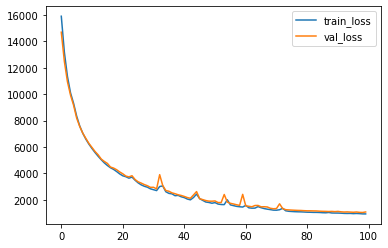

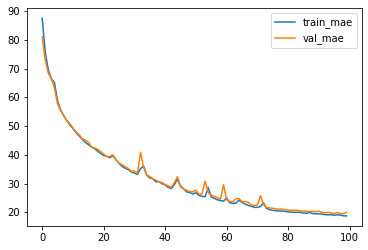

In [24]:
plt.plot(train.epoch, train.history['loss'], label='train_loss')
plt.plot(train.epoch, train.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(train.epoch, train.history['mae'], label='train_mae')
plt.plot(train.epoch, train.history['val_mae'], label='val_mae')
plt.legend()
plt.show()